# Introduction

New York City (NYC), USA is a world famous metropolitan/cosmopolitan city and there is large presence of International community, students, working professionals, Immigrants. There is huge potential for restaurant business considering multi-culture/ethnicity. Asian/Indian is such a large community in NYC and It will help the investors to identify the best location for their upcoming restaurant to attract Indian/Asian students, immigrants and anyone interested in Indian food or multi-cuisine.

The objective of this project is to analyze the Indian restaurants in New York City so that potential customer and investor can have better understanding of the locations which will help them to take decisive action for their investment in restaurant in best location and reap the benefits accordingly. 

This project will leverage IBM Watson platform and Data analysis & visualization tools to solve the below business problems: -

1-	Find the top locations/neighborhoods for Indian restaurants in NYC.

2-	Choose the best location to invest.

## Data

We will use below data sources for Indian Restaurants details: -

1-	Open data source for New York locations and coordinates. (https://cocl.us/new_york_dataset )

2-	Foursquare API to get the venue data for the neighborhoods. (https://developer.foursquare.com/ )

## Methodology

1-	Collect the data from https://cocl.us/new_york_dataset .  Clean and process the data.

2-	Using Foursquare API’s, find all venues for Indian restaurants. 

3-	Sort the data based on rankings.

4-	Analyze and Visualize the data by Python libraries.

## Problem Statement

1. What are the best locations for Indian cuisine in NYC?
2. In what Neighborhood should the investor open a Indian restaurant?
3. Best location in New York City to have the best Indian food?


## Before we get the data and start exploring it, let's import all required libraries .

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests

#from bs4 import BeautifulSoup
import os

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

print('Libraries imported.')  

Solving environment: \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/linux-64::pytorch==1.8.0=cpu_py37hafa7651_0
  - defaults/noarch::ibm-wsrt-py37main-keep==0.0.0=1937
  - defaults/noarch::ibm-wsrt-py37main-main==custom=1937
done

# All requested packages already installed.

Libraries imported.


## My variables

In [2]:
# Define Foursquare Credentials and Version

CLIENT_ID = 'ZDT50SOBAWLXMU5WNY2KSL1PPHZQDDSI2ZRCJV5VPC0P4VMK' # your Foursquare ID
CLIENT_SECRET = '5HCM40SNFZ4FROTTSVU1ZGLFMD3DKHEDKHPYT4CMSM0LKBYF' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

## Now let's define the functions we are going to use later in this project

In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

## Now let's use the above codes to get our initial NYC data

In [4]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [5]:
ny_data.shape

(306, 4)

So there are total of 306 different Neighborhoods in New York.  

## Initial Data Analysis

Now let's analyze our initial data. 

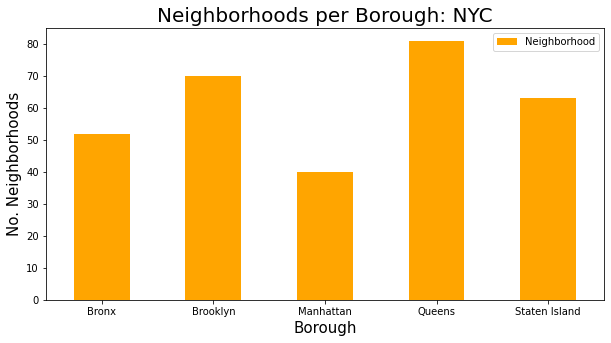

In [6]:
clr = "orange"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

## Let's analyze further and see how many Indian restaurants there are in each neighborhood and borough. After it, graph the results.

In [7]:
# queens has most neighborhoods
# prepare neighborhood list that contains indian restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_restaurants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(ny_data),')','Indian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(indian_restaurants)))
    print(row)
    for resturant_detail in indian_restaurants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Indian Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Indian Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Indian Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Indian Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Indian Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Indian Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Indian Restaurants in Woodlawn, Bronx:1
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Indian Restaurants in Norwood, Bronx:0
['Bronx', '

( 68 / 306 ) Indian Restaurants in Red Hook, Brooklyn:0
['Brooklyn', 'Red Hook', 40.676253230250886, -74.0127589747356]
( 69 / 306 ) Indian Restaurants in Gowanus, Brooklyn:1
['Brooklyn', 'Gowanus', 40.673931143187154, -73.99444087145339]
( 70 / 306 ) Indian Restaurants in Fort Greene, Brooklyn:1
['Brooklyn', 'Fort Greene', 40.68852726018977, -73.97290574369092]
( 71 / 306 ) Indian Restaurants in Park Slope, Brooklyn:0
['Brooklyn', 'Park Slope', 40.67232052268197, -73.97705030183924]
( 72 / 306 ) Indian Restaurants in Cypress Hills, Brooklyn:0
['Brooklyn', 'Cypress Hills', 40.68239101144211, -73.87661596457296]
( 73 / 306 ) Indian Restaurants in East New York, Brooklyn:0
['Brooklyn', 'East New York', 40.669925700847045, -73.88069863917366]
( 74 / 306 ) Indian Restaurants in Starrett City, Brooklyn:0
['Brooklyn', 'Starrett City', 40.64758905230874, -73.87936970045875]
( 75 / 306 ) Indian Restaurants in Canarsie, Brooklyn:0
['Brooklyn', 'Canarsie', 40.63556432797428, -73.90209269778966]


( 132 / 306 ) Indian Restaurants in Jackson Heights, Queens:0
['Queens', 'Jackson Heights', 40.75198138007367, -73.88282109164365]
( 133 / 306 ) Indian Restaurants in Elmhurst, Queens:0
['Queens', 'Elmhurst', 40.744048505122024, -73.88165622288388]
( 134 / 306 ) Indian Restaurants in Howard Beach, Queens:0
['Queens', 'Howard Beach', 40.65422527738487, -73.8381376460028]
( 135 / 306 ) Indian Restaurants in Corona, Queens:0
['Queens', 'Corona', 40.74238175015667, -73.85682497345258]
( 136 / 306 ) Indian Restaurants in Forest Hills, Queens:0
['Queens', 'Forest Hills', 40.72526378216503, -73.84447500788983]
( 137 / 306 ) Indian Restaurants in Kew Gardens, Queens:1
['Queens', 'Kew Gardens', 40.7051790354148, -73.82981905825703]
( 138 / 306 ) Indian Restaurants in Richmond Hill, Queens:0
['Queens', 'Richmond Hill', 40.69794731471763, -73.83183321446887]
( 139 / 306 ) Indian Restaurants in Flushing, Queens:0
['Queens', 'Flushing', 40.76445419697846, -73.83177300329582]
( 140 / 306 ) Indian Re

( 200 / 306 ) Indian Restaurants in Stapleton, Staten Island:0
['Staten Island', 'Stapleton', 40.62692762538176, -74.07790192660066]
( 201 / 306 ) Indian Restaurants in Rosebank, Staten Island:0
['Staten Island', 'Rosebank', 40.61530494652761, -74.06980526716141]
( 202 / 306 ) Indian Restaurants in West Brighton, Staten Island:0
['Staten Island', 'West Brighton', 40.63187892654607, -74.1071817826561]
( 203 / 306 ) Indian Restaurants in Grymes Hill, Staten Island:0
['Staten Island', 'Grymes Hill', 40.624184791313006, -74.08724819983729]
( 204 / 306 ) Indian Restaurants in Todt Hill, Staten Island:0
['Staten Island', 'Todt Hill', 40.59706851814673, -74.1113288180088]
( 205 / 306 ) Indian Restaurants in South Beach, Staten Island:0
['Staten Island', 'South Beach', 40.58024741350956, -74.0795529253982]
( 206 / 306 ) Indian Restaurants in Port Richmond, Staten Island:0
['Staten Island', 'Port Richmond', 40.63366930554365, -74.12943426797008]
( 207 / 306 ) Indian Restaurants in Mariner's Har

( 261 / 306 ) Indian Restaurants in New Lots, Brooklyn:0
['Brooklyn', 'New Lots', 40.6627442796966, -73.88511776379292]
( 262 / 306 ) Indian Restaurants in Paerdegat Basin, Brooklyn:0
['Brooklyn', 'Paerdegat Basin', 40.63131755039667, -73.90233474295836]
( 263 / 306 ) Indian Restaurants in Mill Basin, Brooklyn:0
['Brooklyn', 'Mill Basin', 40.61597423962336, -73.91515391550404]
( 264 / 306 ) Indian Restaurants in Jamaica Hills, Queens:1
['Queens', 'Jamaica Hills', 40.71145964370482, -73.79646462081593]
( 265 / 306 ) Indian Restaurants in Utopia, Queens:0
['Queens', 'Utopia', 40.73350025429757, -73.79671678028349]
( 266 / 306 ) Indian Restaurants in Pomonok, Queens:0
['Queens', 'Pomonok', 40.73493618075478, -73.80486120040537]
( 267 / 306 ) Indian Restaurants in Astoria Heights, Queens:0
['Queens', 'Astoria Heights', 40.7703173929982, -73.89467996270574]
( 268 / 306 ) Indian Restaurants in Claremont Village, Bronx:0
['Bronx', 'Claremont Village', 40.83142834161548, -73.90119903387667]
( 

In [8]:
#indian_rest_ny.to_csv('indian_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare
indian_rest_ny.to_csv('indian_rest_ny_tocsv1.csv') 

In [9]:
indian_ny = pd.read_csv('indian_rest_ny_tocsv1.csv')
indian_rest_ny.tail()

,Borough,Neighborhood,ID,Name
31,Manhattan,Civic Center,50b02338e4b047828b2277c1,Benares
32,Queens,Jamaica Hills,4c434b2bd691c9b6ef8f8f0a,Sagar Restaurant
33,Manhattan,Sutton Place,4a63bfb4f964a520b3c51fe3,Chola Eclectic Indian Cuisine
34,Manhattan,Sutton Place,4fe4fb50c2eee335e4fea69d,Moti Mahal Delux
35,Manhattan,Flatiron,52a1fa08498ede15b1530912,Deep Indian Kitchen


In [10]:
indian_rest_ny.shape

(36, 4)

We got 36 Indian Restaurants across the New York City. 

As we continue our analysis, we see below that although Manhattan had the least number of neighborhoods, it does have the highest number of Indian restaurants. Additionally, we see how many restaurants the top 6 neighborhoods have. The neighborhood of Murray Hill has the highest number of Indian restaurants in all of NYC and is actually located in the boroughs of Manhattan and Queens.

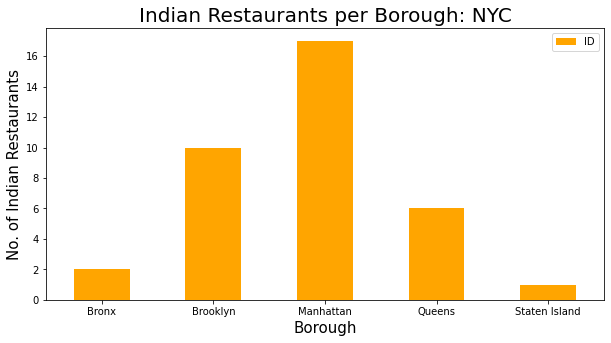

In [11]:
indian_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Indian Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Indian Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

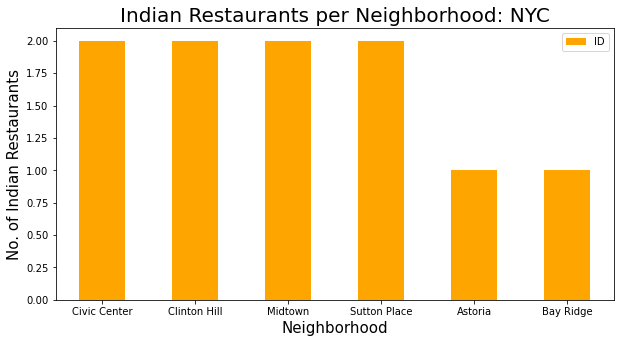

In [12]:
NOofNeigh = 6 # top number for graphing all the same past 6
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Indian Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Indian Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [14]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Civic Center']

,Borough,Neighborhood,ID,Name
30,Manhattan,Civic Center,575dea4c498e2739e43a27e2,Aahar Indian Cuisine
31,Manhattan,Civic Center,50b02338e4b047828b2277c1,Benares


So the Civic Center in Manhattan has the highest number of Indian Restaurants with a total count of 2.

Now we will get the ranking of each restaurant for further analysis.

In [15]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
indian_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '604dd8e87c789a54571d5168'}, 'response': {'venue': {'id': '4c0448d9310fc9b6bf1dc761', 'name': 'Curry Spot', 'contact': {'phone': '7187085900', 'formattedPhone': '(718) 708-5900'}, 'location': {'address': '4268 Katonah Ave', 'crossStreet': 'E 235 Street', 'lat': 40.897624941880906, 'lng': -73.86714729157393, 'labeledLatLngs': [{'label': 'display', 'lat': 40.897624941880906, 'lng': -73.86714729157393}, {'label': 'entrance', 'lat': 40.897709, 'lng': -73.86707}], 'postalCode': '10470', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4268 Katonah Ave (E 235 Street)', 'Bronx, NY 10470', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/curry-spot/4c0448d9310fc9b6bf1dc761', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 

{'meta': {'code': 200, 'requestId': '604dd8e9d1563c033499ce85'}, 'response': {'venue': {'id': '545835a1498e820edc6f636f', 'name': 'Bombay Grill', 'contact': {'phone': '7184912500', 'formattedPhone': '(718) 491-2500'}, 'location': {'address': '8716 3rd Ave', 'lat': 40.622371, 'lng': -74.03179899999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.622371, 'lng': -74.03179899999999}, {'label': 'entrance', 'lat': 40.622344, 'lng': -74.031673}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8716 3rd Ave', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bombay-grill/545835a1498e820edc6f636f', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4

{'meta': {'code': 200, 'requestId': '604dd8eaaa67e67eb8617975'}, 'response': {'venue': {'id': '5169f5c4e4b0c7fcb77a0f3c', 'name': 'Agra Heights', 'contact': {'phone': '7184435700', 'formattedPhone': '(718) 443-5700'}, 'location': {'address': '226 Wilson Ave', 'crossStreet': 'btwn Harman & Himrod St', 'lat': 40.698094445626104, 'lng': -73.92135507234042, 'labeledLatLngs': [{'label': 'display', 'lat': 40.698094445626104, 'lng': -73.92135507234042}, {'label': 'entrance', 'lat': 40.698115, 'lng': -73.921387}], 'postalCode': '11237', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['226 Wilson Ave (btwn Harman & Himrod St)', 'Brooklyn, NY 11237', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/agra-heights/5169f5c4e4b0c7fcb77a0f3c', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/

{'meta': {'code': 200, 'requestId': '604dd8eab4a36b45e5f3cc14'}, 'response': {'venue': {'id': '52f18573498ec2c34e830ffd', 'name': "Kanan's Indian Restaurant", 'contact': {'phone': '7183693777', 'formattedPhone': '(718) 369-3777'}, 'location': {'address': '452 3rd Ave', 'crossStreet': '9th Street', 'lat': 40.671890999999995, 'lng': -73.99094000000001, 'labeledLatLngs': [{'label': 'display', 'lat': 40.671890999999995, 'lng': -73.99094000000001}, {'label': 'entrance', 'lat': 40.671842, 'lng': -73.990867}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['452 3rd Ave (9th Street)', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kanans-indian-restaurant/52f18573498ec2c34e830ffd', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_

{'meta': {'code': 200, 'requestId': '604dd8ebc078f966fea6d9b4'}, 'response': {'venue': {'id': '568d3902498e619efcbc3f58', 'name': 'Spice & Grill', 'contact': {}, 'location': {'address': '441 Myrtle Ave', 'crossStreet': 'Waverly', 'lat': 40.693389, 'lng': -73.968028, 'labeledLatLngs': [{'label': 'display', 'lat': 40.693389, 'lng': -73.968028}], 'postalCode': '11205', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['441 Myrtle Ave (Waverly)', 'Brooklyn, NY 11205', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/spice--grill/568d3902498e619efcbc3f58', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count': 21, 'gro

{'meta': {'code': 200, 'requestId': '604dd8ebccb5ce3c751ec28b'}, 'response': {'venue': {'id': '543870ec498ec64de510608d', 'name': 'Masala Grill', 'contact': {}, 'location': {'address': 'Atlantic Avenue', 'crossStreet': '3rd Avenue', 'lat': 40.68554017378092, 'lng': -73.98120188318653, 'labeledLatLngs': [{'label': 'display', 'lat': 40.68554017378092, 'lng': -73.98120188318653}], 'postalCode': '11217', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['Atlantic Avenue (3rd Avenue)', 'Brooklyn, NY 11217', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/masala-grill/543870ec498ec64de510608d', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 14}, 'url': 'http://masalagrillbk.com', 'price': {'tie

{'meta': {'code': 200, 'requestId': '604dd8eb5c9e6424594b5c80'}, 'response': {'venue': {'id': '4bb93b70cf2fc9b6fe64a002', 'name': 'Gandhi Fine Indian Cuisine', 'contact': {'phone': '7182827012', 'formattedPhone': '(718) 282-7012'}, 'location': {'address': '2032 Bedford Ave', 'crossStreet': 'btwn Clarkson Ave & Parkside Ave', 'lat': 40.65516762218564, 'lng': -73.95632450081226, 'labeledLatLngs': [{'label': 'display', 'lat': 40.65516762218564, 'lng': -73.95632450081226}], 'postalCode': '11226', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2032 Bedford Ave (btwn Clarkson Ave & Parkside Ave)', 'Brooklyn, NY 11226', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/gandhi-fine-indian-cuisine/4bb93b70cf2fc9b6fe64a002', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 's

{'meta': {'code': 200, 'requestId': '604dd8ecc0470e3e31e822ad'}, 'response': {'venue': {'id': '4ae7876ef964a5201eac21e3', 'name': 'Kismat Indian Restaurant', 'contact': {'phone': '2127958633', 'formattedPhone': '(212) 795-8633', 'twitter': 'kismatindian'}, 'location': {'address': '603 Fort Washington Ave', 'crossStreet': '187th St', 'lat': 40.855221723964846, 'lng': -73.93696683600031, 'labeledLatLngs': [{'label': 'display', 'lat': 40.855221723964846, 'lng': -73.93696683600031}], 'postalCode': '10040', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['603 Fort Washington Ave (187th St)', 'New York, NY 10040', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kismat-indian-restaurant/4ae7876ef964a5201eac21e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '

{'meta': {'code': 200, 'requestId': '604dd8ec222e3f1aecba8fe4'}, 'response': {'venue': {'id': '529d382a11d2dd5ef107e641', 'name': 'Chapati House - NYC', 'contact': {'phone': '2127497200', 'formattedPhone': '(212) 749-7200', 'twitter': 'chapatihousenyc'}, 'location': {'address': '3153 Broadway', 'crossStreet': 'Tiemann Pl.', 'lat': 40.81457249971737, 'lng': -73.95915381671377, 'labeledLatLngs': [{'label': 'display', 'lat': 40.81457249971737, 'lng': -73.95915381671377}], 'postalCode': '10027', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3153 Broadway (Tiemann Pl.)', 'New York, NY 10027', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/chapati-house--nyc/529d382a11d2dd5ef107e641', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}

{'meta': {'code': 200, 'requestId': '604dd8ec923f396233b3b53c'}, 'response': {'venue': {'id': '4b0dec08f964a520ae5223e3', 'name': 'Alachi Masala', 'contact': {'phone': '2128747420', 'formattedPhone': '(212) 874-7420', 'twitter': 'alachimasala', 'facebook': '833664873419022', 'facebookName': 'Poona Indian Restaurant'}, 'location': {'address': '488 Amsterdam Ave Frnt 1', 'lat': 40.7861663, 'lng': -73.9764143, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7861663, 'lng': -73.9764143}, {'label': 'entrance', 'lat': 40.78615, 'lng': -73.976343}], 'postalCode': '10024', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['488 Amsterdam Ave Frnt 1', 'New York, NY 10024', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/alachi-masala/4b0dec08f964a520ae5223e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net

{'meta': {'code': 200, 'requestId': '604dd8ed1d22ba42e7ebab54'}, 'response': {'venue': {'id': '5953e40462420b044e8989f4', 'name': 'indikitch', 'contact': {'phone': '6464819905', 'formattedPhone': '(646) 481-9905', 'twitter': 'indikitch', 'instagram': 'indikitch'}, 'location': {'address': '1190 6th Avenue', 'lat': 40.75768139999999, 'lng': -73.9818088, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75768139999999, 'lng': -73.9818088}], 'postalCode': '10036', 'cc': 'US', 'neighborhood': 'Midtown East', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1190 6th Avenue', 'New York, NY 10036', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/indikitch/5953e40462420b044e8989f4', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False,

{'meta': {'code': 200, 'requestId': '604dd8ed5c9e6424594b6179'}, 'response': {'venue': {'id': '4b4aab62f964a520978c26e3', 'name': 'Dil-e Punjab Deli', 'contact': {'phone': '2126479428', 'formattedPhone': '(212) 647-9428', 'twitter': 'dilepunjabdeli'}, 'location': {'address': '170 9th Ave', 'crossStreet': 'at 21st St', 'lat': 40.74484451009235, 'lng': -74.00252750283143, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74484451009235, 'lng': -74.00252750283143}, {'label': 'entrance', 'lat': 40.744917, 'lng': -74.002266}], 'postalCode': '10011', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['170 9th Ave (at 21st St)', 'New York, NY 10011', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dile-punjab-deli/4b4aab62f964a520978c26e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/f

{'meta': {'code': 200, 'requestId': '604dd8ee1d22ba42e7ebaccb'}, 'response': {'venue': {'id': '56c931b2cd10407d3ecbefda', 'name': 'Ananda', 'contact': {}, 'location': {'address': '210 Thompson St', 'crossStreet': 'btwn W 3rd & Bleecker Sts', 'lat': 40.72883889496238, 'lng': -73.9993364782382, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72883889496238, 'lng': -73.9993364782382}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['210 Thompson St (btwn W 3rd & Bleecker Sts)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ananda/56c931b2cd10407d3ecbefda', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 20}, 'url': 'http://www.ahimsa.nyc', '

{'meta': {'code': 200, 'requestId': '604dd8ef31e8773ab70401b2'}, 'response': {'venue': {'id': '5803c0db38fa71491b748a7d', 'name': 'Taco Mahal', 'contact': {'phone': '6467191553', 'formattedPhone': '(646) 719-1553', 'instagram': 'tacomahalnyc', 'facebook': '575545749278543', 'facebookUsername': 'TacoMahalnyc', 'facebookName': 'Taco Mahal'}, 'location': {'address': '73 7th Ave S', 'lat': 40.73240508476288, 'lng': -74.00350113625272, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73240508476288, 'lng': -74.00350113625272}], 'postalCode': '10014', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['73 7th Ave S', 'New York, NY 10014', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/taco-mahal/5803c0db38fa71491b748a7d', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 's

{'meta': {'code': 200, 'requestId': '604dd8ef9be62865278efe8d'}, 'response': {'venue': {'id': '5d8d9c5e0a2ffc0008f28855', 'name': 'The Gully', 'contact': {'phone': '7188873933', 'formattedPhone': '(718) 887-3933'}, 'location': {'address': '2545 Steinway St', 'lat': 40.766719, 'lng': -73.91241, 'labeledLatLngs': [{'label': 'display', 'lat': 40.766719, 'lng': -73.91241}], 'postalCode': '11103', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2545 Steinway St', 'New York, NY 11103', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/the-gully/5d8d9c5e0a2ffc0008f28855', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'

{'meta': {'code': 200, 'requestId': '604dd8f0b2d4e616c5cdfafb'}, 'response': {'venue': {'id': '50a287a7e4b0033f830f06db', 'name': "Raj's Indian Kitchen", 'contact': {'phone': '7183618844', 'formattedPhone': '(718) 361-8844'}, 'location': {'address': '27-18 Queens Plz S', 'lat': 40.74997632892085, 'lng': -73.93926056994543, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74997632892085, 'lng': -73.93926056994543}], 'postalCode': '11101', 'cc': 'US', 'city': 'Long Island City', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['27-18 Queens Plz S', 'Long Island City, NY 11101', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/rajs-indian-kitchen/50a287a7e4b0033f830f06db', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 13

{'meta': {'code': 200, 'requestId': '604dd8f0b967997a39044a45'}, 'response': {'venue': {'id': '4b3a8aa5f964a520996925e3', 'name': 'Sajni 026', 'contact': {'phone': '7182750606', 'formattedPhone': '(718) 275-0606'}, 'location': {'address': '9810 Queens Blvd', 'crossStreet': '65th Rd.', 'lat': 40.728123, 'lng': -73.858071, 'labeledLatLngs': [{'label': 'display', 'lat': 40.728123, 'lng': -73.858071}, {'label': 'entrance', 'lat': 40.728194, 'lng': -73.85792}], 'postalCode': '11374', 'cc': 'US', 'city': 'Rego Park', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['9810 Queens Blvd (65th Rd.)', 'Rego Park, NY 11374', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sajni-026/4b3a8aa5f964a520996925e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False

{'meta': {'code': 200, 'requestId': '604dd8f17c676a3ae1fc60b2'}, 'response': {'venue': {'id': '5a1e961c1987ec47beed877d', 'name': 'Baar Baar', 'contact': {'phone': '2122281200', 'formattedPhone': '(212) 228-1200', 'twitter': 'baarbaarnyc', 'instagram': 'baarbaarnyc', 'facebook': '478023699251632', 'facebookUsername': 'baarbaarnyc', 'facebookName': 'Baar Baar'}, 'location': {'address': '13 E 1st St', 'crossStreet': 'btw Bowery & 2nd Ave', 'lat': 40.724533801523286, 'lng': -73.99162419418478, 'labeledLatLngs': [{'label': 'display', 'lat': 40.724533801523286, 'lng': -73.99162419418478}], 'postalCode': '10003', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['13 E 1st St (btw Bowery & 2nd Ave)', 'New York, NY 10003', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/baar-baar/5a1e961c1987ec47beed877d', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'In

{'meta': {'code': 200, 'requestId': '604dd8f1d799930a42ab4f28'}, 'response': {'venue': {'id': '50b02338e4b047828b2277c1', 'name': 'Benares', 'contact': {'phone': '2129670400', 'formattedPhone': '(212) 967-0400'}, 'location': {'address': '45 Murray St', 'crossStreet': 'Park Place', 'lat': 40.714117, 'lng': -74.009248, 'labeledLatLngs': [{'label': 'display', 'lat': 40.714117, 'lng': -74.009248}], 'postalCode': '10007', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['45 Murray St (Park Place)', 'New York, NY 10007', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/benares/50b02338e4b047828b2277c1', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 44}, 'url': 'http://www.benaresnyc.com', 'pri

{'meta': {'code': 200, 'requestId': '604dd8f1d799930a42ab4ff4'}, 'response': {'venue': {'id': '4c434b2bd691c9b6ef8f8f0a', 'name': 'Sagar Restaurant', 'contact': {'phone': '7182985696', 'formattedPhone': '(718) 298-5696'}, 'location': {'address': '168-25 B Hillside Ave', 'lat': 40.710328623498505, 'lng': -73.79412262466633, 'labeledLatLngs': [{'label': 'display', 'lat': 40.710328623498505, 'lng': -73.79412262466633}], 'postalCode': '11432', 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['168-25 B Hillside Ave', 'Jamaica, NY 11432', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sagar-restaurant/4c434b2bd691c9b6ef8f8f0a', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'url': 'http://

{'meta': {'code': 200, 'requestId': '604dd8f2a2c86b7b8ab8acc8'}, 'response': {'venue': {'id': '4fe4fb50c2eee335e4fea69d', 'name': 'Moti Mahal Delux', 'contact': {'phone': '2123713535', 'formattedPhone': '(212) 371-3535', 'twitter': 'motimahalus', 'facebook': '464790890213866', 'facebookUsername': 'MotiMahalDeluxNYC', 'facebookName': 'Moti Mahal Delux, NYC'}, 'location': {'address': '1149 1st Ave', 'crossStreet': '63rd Street', 'lat': 40.76209761945207, 'lng': -73.96028513480461, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76209761945207, 'lng': -73.96028513480461}, {'label': 'entrance', 'lat': 40.762073, 'lng': -73.960379}], 'postalCode': '10065', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1149 1st Ave (63rd Street)', 'New York, NY 10065', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/moti-mahal-delux/4fe4fb50c2eee335e4fea69d', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'plura

{'meta': {'code': 200, 'requestId': '604dd8f243a37f7e1515c059'}, 'response': {'venue': {'id': '52a1fa08498ede15b1530912', 'name': 'Deep Indian Kitchen', 'contact': {'phone': '6465907152', 'formattedPhone': '(646) 590-7152', 'twitter': 'indikitch', 'instagram': 'deepindiankitchen_restaurant'}, 'location': {'address': '25 W 23rd St', 'crossStreet': 'btwn 5th & 6th Ave', 'lat': 40.742025061405144, 'lng': -73.99055792757031, 'labeledLatLngs': [{'label': 'display', 'lat': 40.742025061405144, 'lng': -73.99055792757031}], 'postalCode': '10010', 'cc': 'US', 'neighborhood': 'NoMad', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['25 W 23rd St (btwn 5th & 6th Ave)', 'New York, NY 10010', 'United States']}, 'canonicalUrl': 'https://foursquare.com/indikitch', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/ind

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
31,Manhattan,Civic Center,50b02338e4b047828b2277c1,Benares,97,7.6,44
32,Queens,Jamaica Hills,4c434b2bd691c9b6ef8f8f0a,Sagar Restaurant,10,7.2,6
33,Manhattan,Sutton Place,4a63bfb4f964a520b3c51fe3,Chola Eclectic Indian Cuisine,155,8.2,58
34,Manhattan,Sutton Place,4fe4fb50c2eee335e4fea69d,Moti Mahal Delux,186,8.3,83
35,Manhattan,Flatiron,52a1fa08498ede15b1530912,Deep Indian Kitchen,680,8.3,132


In [16]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny_csv.csv') # save data to a .csv file 

In [17]:
indian_rest_stats_ny.shape

(36, 7)

We got statistics for all 36 Indian Restaurants in New York city. 

Let's check what values we have in our DataFrame

In [18]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       36 non-null     object 
 1   Neighborhood  36 non-null     object 
 2   ID            36 non-null     object 
 3   Name          36 non-null     object 
 4   Likes         36 non-null     object 
 5   Rating        36 non-null     float64
 6   Tips          36 non-null     object 
dtypes: float64(1), object(6)
memory usage: 2.1+ KB


We see that the values like Likes, Tips are string values. We would need to convert them into float for further analysis

In [19]:
indian_rest_stats_ny['Likes'] = indian_rest_stats_ny['Likes'].astype('float64')
indian_rest_stats_ny['Tips'] = indian_rest_stats_ny['Tips'].astype('float64')
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       36 non-null     object 
 1   Neighborhood  36 non-null     object 
 2   ID            36 non-null     object 
 3   Name          36 non-null     object 
 4   Likes         36 non-null     float64
 5   Rating        36 non-null     float64
 6   Tips          36 non-null     float64
dtypes: float64(3), object(4)
memory usage: 2.1+ KB


## Now when the data types look correct, let's continue our analysis.

In [20]:
indian_rest_stats_ny.describe()

,Likes,Rating,Tips
count,36.000000,36.000000,36.000000
mean,106.500000,7.747222,33.305556
std,191.008078,0.864700,50.582221
min,3.000000,5.700000,2.000000
25%,17.000000,7.500000,7.500000
50%,39.500000,7.900000,17.000000
75%,86.500000,8.300000,30.000000
max,834.000000,9.100000,256.000000


In [21]:
# Resturant with maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                              834.0
Rating                               8.6
Tips                               256.0
Name: 16, dtype: object

In [22]:
# Resturant with maximum Ratings
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                              601.0
Rating                               9.1
Tips                               151.0
Name: 20, dtype: object

In [23]:
# Resturant with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                              834.0
Rating                               8.6
Tips                               256.0
Name: 16, dtype: object

## Now let's identify and visualize neighborhood with the maximum average rating of restaurants

In [24]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
26,Tribeca,9.10
22,Noho,8.70
23,Prospect Lefferts Gardens,8.70
6,Chelsea,8.70
10,Fort Greene,8.50
30,West Village,8.50
13,Greenwich Village,8.40
20,Midtown,8.35
9,Flatiron,8.30
25,Sutton Place,8.25


Above are the top neighborhoods with the highest average ratings of Indian restaurants.

In [25]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.229412
4,Staten Island,8.200000
3,Queens,7.400000
1,Brooklyn,7.300000
0,Bronx,6.700000


Similarly these are the average ratings of Indian Restaurants for each Borough

## Let's visualize the results

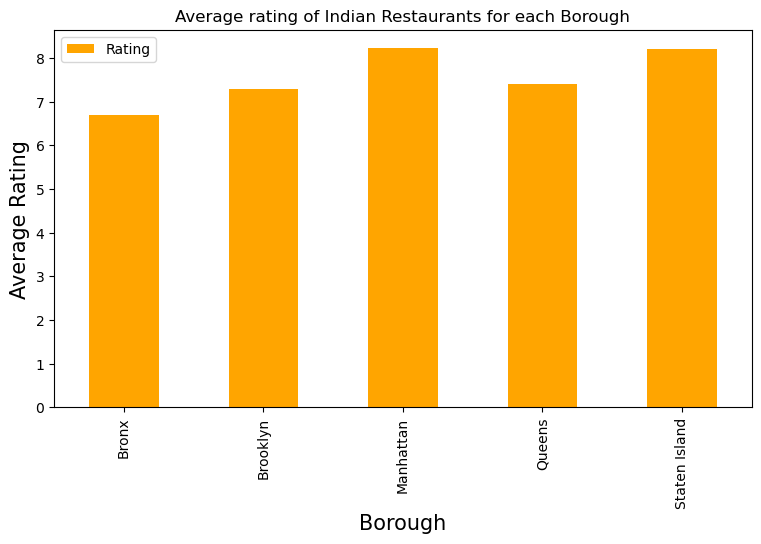

In [26]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Indian Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()

We will consider all the neighborhoods with average rating greater or equal 8.0 to visualize on a map

In [27]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Astoria,8.00
2,Bayside,8.10
3,Boerum Hill,8.00
6,Chelsea,8.70
9,Flatiron,8.30
10,Fort Greene,8.50
13,Greenwich Village,8.40
20,Midtown,8.35
21,New Dorp,8.20
22,Noho,8.70


We will join this Dataset to original New York data to get longitude and latitude

In [28]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Astoria,40.768509,-73.915654,8.00
1,Queens,Bayside,40.766041,-73.774274,8.10
2,Brooklyn,Boerum Hill,40.685683,-73.983748,8.00
3,Manhattan,Chelsea,40.744035,-74.003116,8.70
4,Staten Island,Chelsea,40.594726,-74.189560,8.70
5,Manhattan,Flatiron,40.739673,-73.990947,8.30
6,Brooklyn,Fort Greene,40.688527,-73.972906,8.50
7,Manhattan,Greenwich Village,40.726933,-73.999914,8.40
8,Manhattan,Midtown,40.754691,-73.981669,8.35
9,Staten Island,New Dorp,40.572572,-74.116479,8.20


Now we will show this data on a map

In [29]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Let's add a new field to dataframe for labeling purpose

In [30]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)

## Results / Conclusion 

Based on the results of our analysis, Manhattan and Brooklyn are the best locations for Indian restaurants in NYC. 

Manhattan is preferred location to open a new Indian restaurant followed by Brooklyn.

In Manhattan, neighborhoods like Tribeca & Noho are the best places to open a new Indian restaurant.
